In [1]:
import time
import torch
import glob
import cv2
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from sklearn.metrics import r2_score

In [51]:
path_wiki = 'data/watches/ds1_kaggle/cleandata.csv'
path_imdb = 'data/watches/ds1_kaggle/images/'
img_size = 255

In [7]:
#The following code is based on and in parts taken from: https://medium.com/analytics-vidhya/creating-a-custom-dataset-and-dataloader-in-pytorch-76f210a1df5d
class WatchDataset(Dataset):
    def __init__(self):
        df = pd.read_csv(path_wiki)
        
        self.imgs_path = df["image_name"]
        self.price = df["price"]
        
        self.data = []
        for index, row in df.iterrows():
            self.data.append([row["image_name"], row["price"]])
        
        self.img_dim = (img_size, img_size) #original Images 406x512 -> /7 = 
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, price = self.data[idx]
        img = cv2.imread(path_imdb + img_path)
        #print("Image Path: " + "data/watches/kaggle_data/images" + img_path)
        #print(img)
        img = cv2.resize(img, self.img_dim)
        
        img_tensor = torch.from_numpy(img)
        img_tensor = img_tensor.permute(2, 0, 1)
        img_tensor = img_tensor.float()
        
        price = torch.tensor([price]) #unsicher ob man das überhaupt machen muss
        return img_tensor[0], price.float()

In [59]:
dataset = WatchDataset()

In [6]:
print(f" Width of one image is {len(dataset[0][0][0])}")

 Width of one image is 255


In [7]:
print(f" Pictures in the Dataset: {len(dataset)}")

 Pictures in the Dataset: 2553


In [8]:
def get_watch_inf_from_dataset(dataset_element):
    plt.imshow(dataset_element[0])
    print(f"Watch Price: {float(dataset_element[1][0])}")

Watch Price: 2780.0


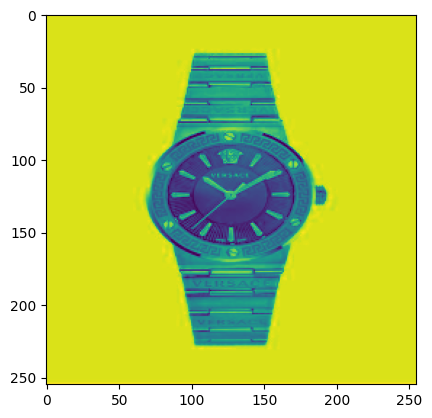

In [9]:
get_watch_inf_from_dataset(dataset[0])

## Initialize and set up the NeuralNetwork

In the next codeblock I buld the neural newtork:

In [3]:
#The following code is based on and in parts taken from the lectures repository: https://git.dhbw-stuttgart.de/tobias.hoelzer/adv-ml
class NeuralNetwork(torch.nn.Module):

    def __init__(self, hidden_features=10584):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential(
            torch.nn.Linear(img_size * img_size, 10584),
            torch.nn.ReLU(),
            torch.nn.Linear(10584, 5000),
            torch.nn.ReLU(),
            torch.nn.Linear(5000, 2500),
            torch.nn.ReLU(),
            torch.nn.Linear(2500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1),
            #torch.nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

## Test the Neural Network with one single Image

In [11]:
train_dataloader = DataLoader(dataset, batch_size=1)

In [12]:
NN = NeuralNetwork()
X, y = next(iter(train_dataloader))
print(f"Price of Watch: {y}")
print(f"Result from NN: {NN(X)}")
print(f"Batch length: {len(NN(X))}")
loss_fn = torch.nn.MSELoss()
print(f"Result from loss funktion: {loss_fn(NN(X), y)}")

Price of Watch: tensor([[2780.]])
Result from NN: tensor([[3.3595]], grad_fn=<AddmmBackward0>)
Batch length: 1
Result from loss funktion: 7709733.0


## Set calculation for R2 Metric

In [13]:
def r_squared(y_pred, y_true):
    y_mean = torch.mean(y_true)
    ss_total = torch.sum((y_true - y_mean) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [14]:
#The following code is based on and in parts taken from the lectures repository: https://git.dhbw-stuttgart.de/tobias.hoelzer/adv-ml
def train_loop(dataloader, model, loss_fn, optimizer, device="cpu"):
    for X, y in dataloader:
        # Move data to device
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        #print(pred)
        #loss_fn = torch.nn.MSELoss()
        loss = loss_fn(pred, y)
        #print(loss)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def test_loop(dataloader, model, loss_fn, device="cpu"):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct_div, r2 = 0, 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            # Move data to device
            X, y = X.to(device), y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y)
            metric = torch.nn.L1Loss()
            correct_div += metric(pred, y)
            r2 += r_squared(pred, y)
            

    test_loss /= num_batches
    correct_div /= num_batches
    r2 /= num_batches
    #print(f"L1Loss: {correct_div:>0.1f}, Avg loss: {test_loss} , Pred: {pred}, Y: {y}")  #:>8f -> ") #
    print(f"L1Loss: {correct_div:>0.1f}, Avg loss: {test_loss}, R2: {r2} ")

In [11]:
# Set Hyperparameter
LEARNING_RATE = 1e-9
BATCH_SIZE = 64
EPOCHS = 8

In [16]:
train_data, val_data, test_data = torch.utils.data.random_split(dataset, [0.8, 0.0, 0.2])

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

/Users/apple/Library/Caches/pypoetry/virtualenvs/watch-price-prediction-3DOoTniV-py3.11/lib/python3.11/site-packages/torch/utils/data/dataset.py:348: UserWarning: Length of split at index 1 is 0. This might result in an empty dataset.
  warnings.warn(f"Length of split at index {i} is 0. "


In [17]:
### TIME INFORMATION: needs 18 Minutes to finish the cpu of a i7-4790K 4GHz IMac
### TIME INFORMATION: needs 5 Minutes with 20example pictures on M1 mps

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

# Init model and move to GPU
# Needlessly make the model more complex with large hidden-layer size
model = NeuralNetwork(hidden_features=2048) 
model.to(device)

# Define loss function and init optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

# Measure time for training
start_time = time.time()
print(f"Train on {device}")
for t in range(EPOCHS):
    print(f"Epoch {t+1} -------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loop(test_dataloader, model, loss_fn, device)
print(f"Done in {time.time() - start_time:.2f}s!")

Train on cpu
Epoch 1 -------------------------------
L1Loss: 401.1, Avg loss: 357085.375, R2: -0.9637647867202759 
Epoch 2 -------------------------------
L1Loss: 380.8, Avg loss: 341407.28125, R2: -0.8629485368728638 
Epoch 3 -------------------------------
L1Loss: 358.7, Avg loss: 325169.84375, R2: -0.7593161463737488 
Epoch 4 -------------------------------
L1Loss: 334.8, Avg loss: 307474.71875, R2: -0.6475623250007629 
Epoch 5 -------------------------------
L1Loss: 310.7, Avg loss: 288266.625, R2: -0.5279430150985718 
Epoch 6 -------------------------------
L1Loss: 286.5, Avg loss: 267584.0, R2: -0.40180113911628723 
Epoch 7 -------------------------------
L1Loss: 267.5, Avg loss: 247238.078125, R2: -0.281790167093277 
Epoch 8 -------------------------------
L1Loss: 256.1, Avg loss: 229115.25, R2: -0.1807204782962799 
Done in 1138.75s!


In [14]:
def get_model_prediction(dataloader, model, device):
    predictions = []
    real_values = []
    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        model_results = model(X)
        for pred in model_results:
            predictions.append(pred[0].item())
        for y_values in y:
            real_values.append(y_values.item())
    return predictions, real_values

In [19]:
y_pred_train, y_train = get_model_prediction(train_dataloader, model, device)
y_pred, y_test = get_model_prediction(test_dataloader, model, device)

In [22]:
print(f"The R2 score of the model on the Test Data is: {r2_score(y_test, y_pred)}")
print(f"The R2 score of the model on the Train Data is: {r2_score(y_train, y_pred_train)}")

The R2 score of the model on the Test Data is: -0.1688883817180098
The R2 score of the model on the Train Data is: -0.1978535476318788


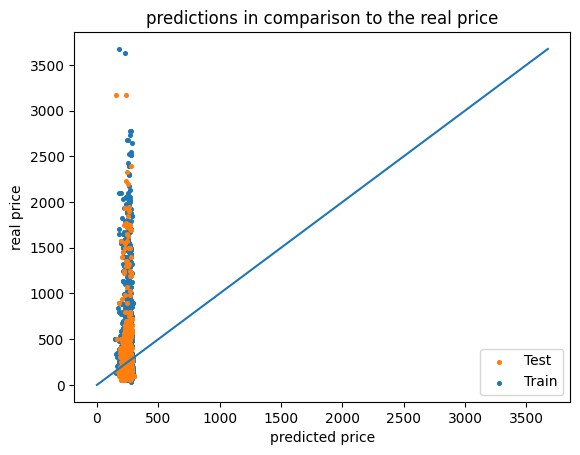

In [23]:
fig, ax = plt.subplots()

train = ax.scatter(y_pred_train, y_train, s=7, label ="Train")
test = ax.scatter(y_pred, y_test, s=7, label= "Test")

ax.plot([0,max(y_train)], [0,max(y_train)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('predictions in comparison to the real price')

ax.legend(handles=[test, train], loc='lower right')

plt.show()

In [24]:
## save model to storage
with open("models/M2_NN_ds1.pickle", mode="wb") as out_file:
    pickle.dump(model, out_file)

## Load and Test DS 2

In [21]:
path_wiki = 'data/watches/ds2_marc/cleandata.csv'
path_imdb = 'data/watches/ds2_marc/images/'

In [22]:
dataset2 = WatchDataset()
test_dataloader_df_ds2 = DataLoader(dataset2, batch_size=BATCH_SIZE)

In [23]:
y_pred_ds2, all_label_ds2 = get_model_prediction(test_dataloader_df_ds2, model, device)

In [24]:
print(f"The R2 score on not filtered Marc Gebauer Data is: {r2_score(all_label_ds2, y_pred_ds2)}")

The R2 score on not filtered Marc Gebauer Data is: -0.3178315011125259


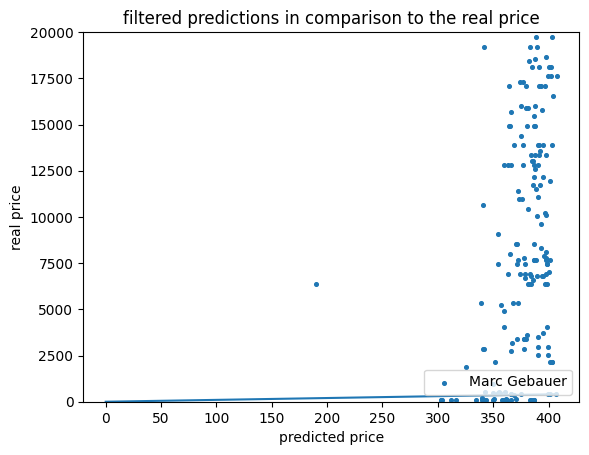

In [27]:
fig, ax = plt.subplots()

test = ax.scatter(y_pred_ds2, all_label_ds2, s=7, label ="Marc Gebauer")

ax.plot([0,max(y_pred_ds2)], [0,max(y_pred_ds2)])
ax.set_ylabel('real price')
ax.set_xlabel('predicted price')
ax.set_title('filtered predictions in comparison to the real price')

ax.legend(handles=[test], loc='lower right')
ax.set_ylim(0, 20000)  
#ax.set_xlim(0, 20000)  

plt.show()